# Exp 001

In [2]:
import os
import shutil
import time
import pickle
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from nets.snet import *
from tqdm import tqdm
from ds.seq import *

import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
np.set_printoptions(suppress=True)

In [2]:
def init_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
init_random_seed(1234)

In [3]:
def set_gpu_memory_growth_mode(gpu_id=0):
    import tensorflow as tf
    # tf.config.gpu.set_per_process_memory_growth(True) --> TF 1.x
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if not gpus:
        return
    try:
        tf.config.experimental.set_memory_growth(gpus[gpu_id], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
set_gpu_memory_growth_mode()

In [4]:
def archive_weights(model):
    return [(v.name, v.numpy()) for v in model.trainable_variables]

In [5]:
def make_loss_fn():
    @tf.function
    def gaze_loss(label, pred):
        return tf.reduce_mean(tf.losses.mse(label, pred))
    return gaze_loss
 
def get_mean_distance_metric():
    def mean_distance(y_true, y_pred):
        square = tf.math.square(y_pred - y_true)
        reduce_sum = tf.math.reduce_sum(square, axis=1)
        dists = tf.math.sqrt(reduce_sum)
        return tf.math.reduce_mean(dists)
    return mean_distance
    
def make_model():
    net = SNet.create()
    l = make_loss_fn()
    lr = tf.keras.experimental.CosineDecayRestarts(1e-5, 10)
    # o = tf.keras.optimizers.SGD(learning_rate=lr)
    o = tf.keras.optimizers.Adam(learning_rate=0.001)
    m = [get_mean_distance_metric()]
    net.compile(loss=l, optimizer=o, metrics=m)
    return net

def lr_schedule(epoch):
        learning_rate = 0.01
        if epoch > 10:
            learning_rate = 0.005
        if epoch > 20:
            learning_rate = 0.001
        if epoch > 50:
            learning_rate = 0.0008
        if epoch > 80:
            learning_rate = 0.00001
        tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
        return learning_rate
    
def get_callbacks():
    lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    return []

# 데이터셋 

In [6]:
def load_dataset(gc_root_path, profiles, batch_size=32):
    data_bag = {}
    for pid in profiles:
        train = Sequence('train', pid, gc_root_path, batch_size=batch_size)
        valid = Sequence('valid', pid, gc_root_path, batch_size=batch_size)
        data_bag[pid] = { 't': train, 'v': valid }
    
    # sample shape show
    v = data_bag[profiles[0]]['v']
    inputs, targets = v[0]
    print(inputs[2].shape)
    print(inputs[0].shape)
    return data_bag

def cross_eval(m, data_bag, profiles):
    for pid in profiles:
        bag = data_bag[pid]
        t, v = bag['t'], bag['v']
        loss, metrics = m.evaluate(v, verbose=1, max_queue_size=10, workers=4)
        print("{} 평가".format(pid, loss, metrics))
        
def ce():
    cross_eval(model, data_bag, ps)

def train_epoch(m, data_bag, profile_id, snapshots, epochs=1, shuffle=False):
    bag = data_bag[profile_id]
    res = m.fit_generator(bag['t'], validation_data=bag['v'], epochs=epochs, verbose=1, 
                          shuffle=shuffle, callbacks=get_callbacks())
    w = archive_weights(model)
    s = (profile_id, w, res)
    snapshots.append(s)
    return res

def q(pid, epochs=1):
    for e in range(epochs):
        res = train_epoch(model, data_bag, pid, snapshots, epochs=1)
        print(">>> P[{}]: e[{}] snapshot: [{}]".format(pid, e, len(snapshots)-1))

def compare(x, y):
    num_entry = len(snapshots)
    if x >= num_entry or y >= num_entry:
        print("only:", num_entry)
        return
    
    w_x, w_y = snapshots[x][1], snapshots[y][1]
    for i in range(0, len(w_x)):
        draw_weight_compare(w_x, w_y, i, (8,8))

In [7]:
snapshots = []
model = make_model()

In [8]:
# ps = ['01744', '02334', '02700', '01054', '01055', '02666']
ps = ['01050', '01051', '01054', '01055', '02666']
# ps = ['02342', '02349', '02450', '01905', '01054', '01055']
data_bag = load_dataset("/home/elvin/banner/mnt/ssd3/nps", ps)

(32, 42)
(32, 128, 128, 3)


In [9]:
stop

NameError: name 'stop' is not defined

In [11]:
q(ps[2], 20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 35 steps
53/53 [==============================] - 7s 128ms/step - loss: 4.9703 - mean_distance: 2.7081 - val_loss: 8.6866 - val_mean_distance: 3.5254
>>> P[01054]: e[0] snapshot: [20]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 35 steps
53/53 [==============================] - 7s 130ms/step - loss: 2.6080 - mean_distance: 1.9663 - val_loss: 4.4660 - val_mean_distance: 2.4767
>>> P[01054]: e[1] snapshot: [21]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 35 steps
53/53 [==============================] - 7s 127ms/step - loss: 1.6237 - mean_distance: 1.5436 - val_loss: 2.4296 - val_mean_distance: 1.8617
>>> P[01054]: e[2] snapshot: [22]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 35 steps
53/53 [==============================] - 7s 126ms/step - loss: 1.0918 - mean_distance: 1.2616 - val_loss: 1

In [12]:
ce()

  ...
    to  
  ['...']
26/26 [==============================] - 1s 34ms/step - loss: 18.3614 - mean_distance: 5.3946
01050 평가
  ...
    to  
  ['...']
23/23 [==============================] - 1s 36ms/step - loss: 17.5842 - mean_distance: 5.2144
01051 평가
  ...
    to  
  ['...']
35/35 [==============================] - 1s 33ms/step - loss: 1.0756 - mean_distance: 1.2185
01054 평가
  ...
    to  
  ['...']
33/33 [==============================] - 1s 35ms/step - loss: 14.0496 - mean_distance: 4.7531
01055 평가
  ...
    to  
  ['...']
28/28 [==============================] - 1s 36ms/step - loss: 6.9168 - mean_distance: 3.2729: 0s - loss: 7.0511 - mean_distance: 3.30
02666 평가


>>> name:l_stem_conv/kernel:0 weight shape: (3, 3, 3, 32)


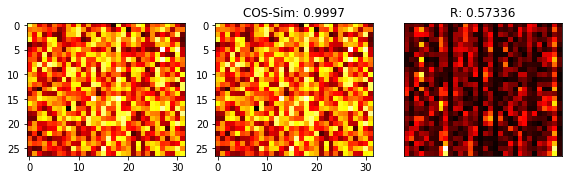

>>> name:r_stem_conv/kernel:0 weight shape: (3, 3, 3, 32)


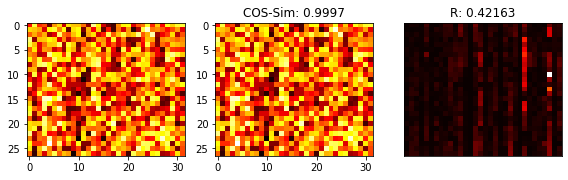

>>> name:stage_l2_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 32, 32)


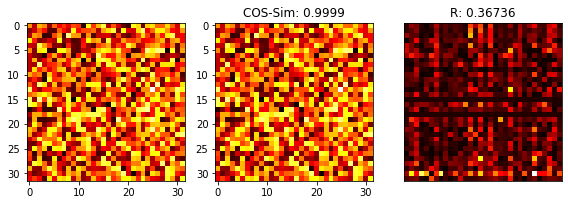

>>> name:stage_r2_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 32, 32)


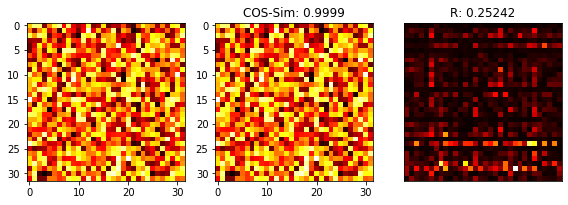

>>> name:stage_l2_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


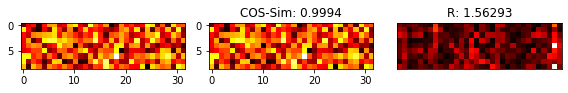

>>> name:stage_l2_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


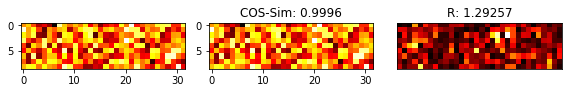

>>> name:stage_r2_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


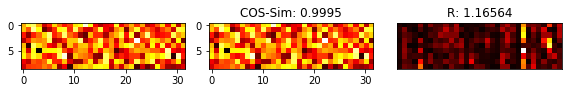

>>> name:stage_r2_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


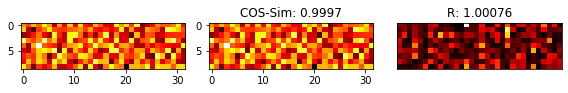

>>> name:stage_l2_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 32, 32)


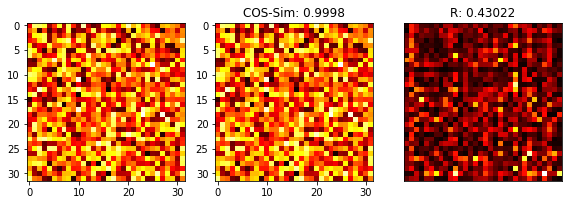

>>> name:stage_l2_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


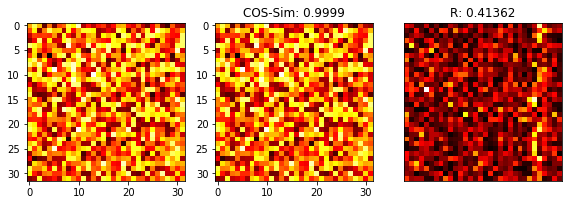

>>> name:stage_r2_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 32, 32)


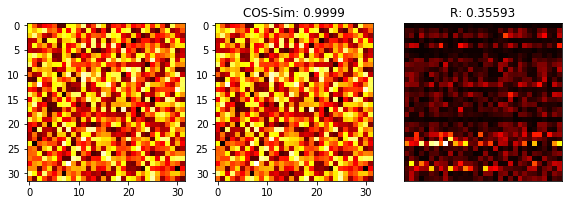

>>> name:stage_r2_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


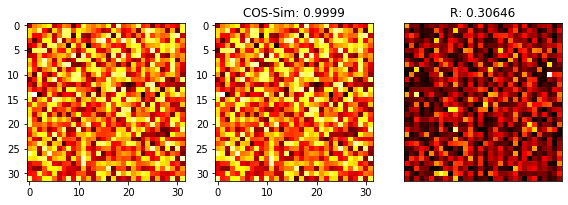

>>> name:stage_l2_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


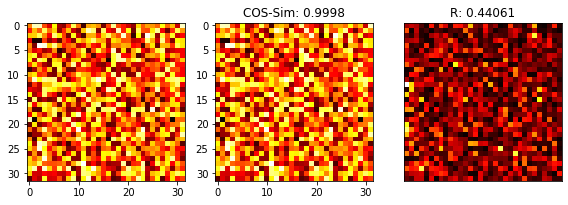

>>> name:stage_r2_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


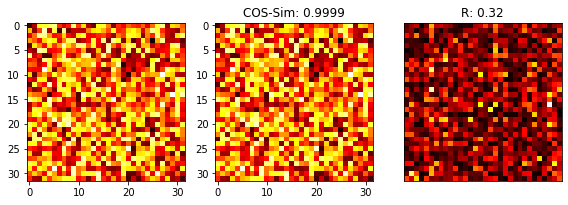

>>> name:stage_l2_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


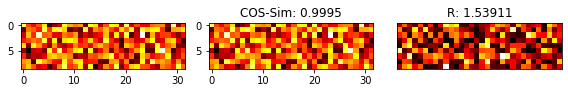

>>> name:stage_r2_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


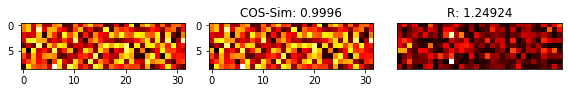

>>> name:stage_l2_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


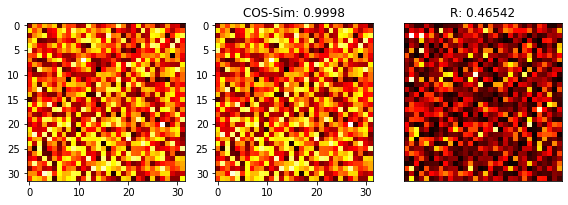

>>> name:stage_r2_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


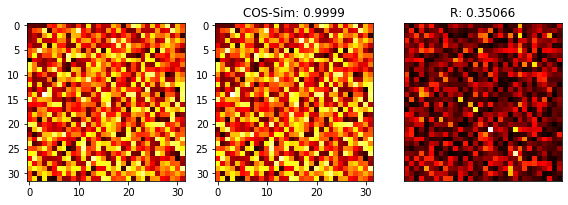

>>> name:stage_l3_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 64, 32)


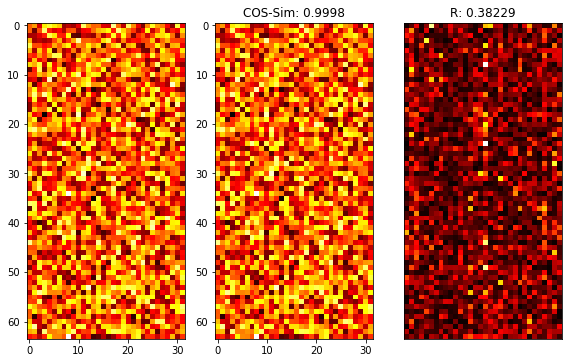

>>> name:stage_r3_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 64, 32)


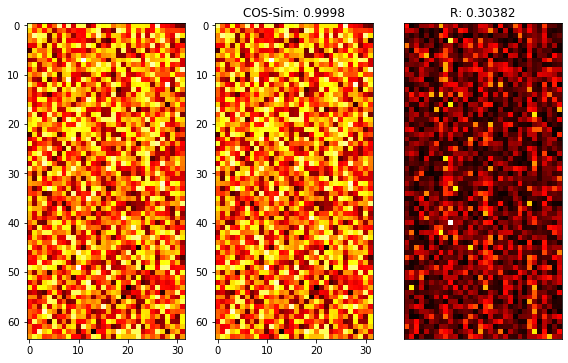

>>> name:stage_l3_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 64, 1)


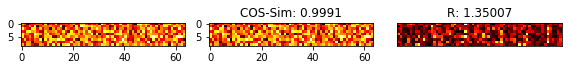

>>> name:stage_l3_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


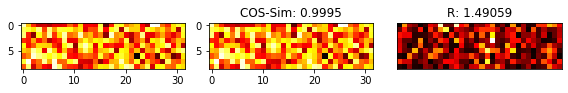

>>> name:stage_r3_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 64, 1)


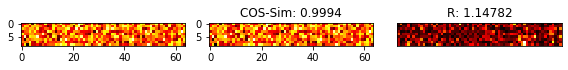

>>> name:stage_r3_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


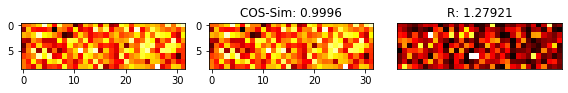

>>> name:stage_l3_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 64, 32)


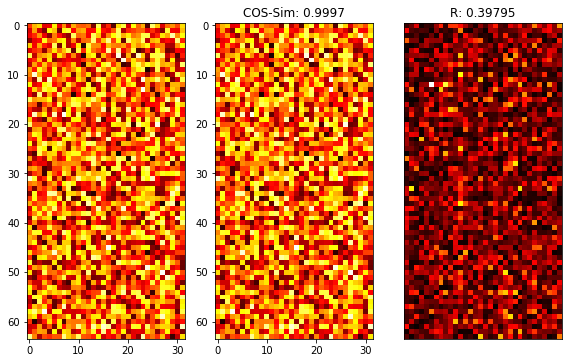

>>> name:stage_l3_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


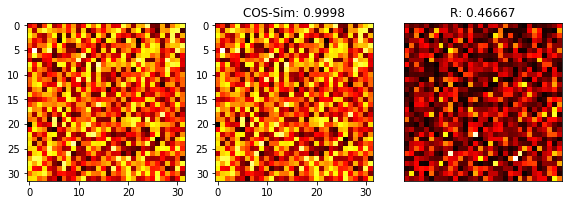

>>> name:stage_r3_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 64, 32)


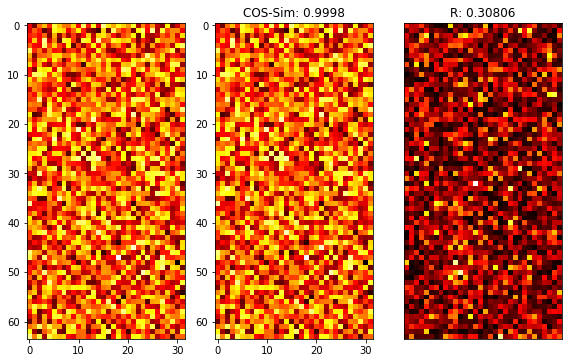

>>> name:stage_r3_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


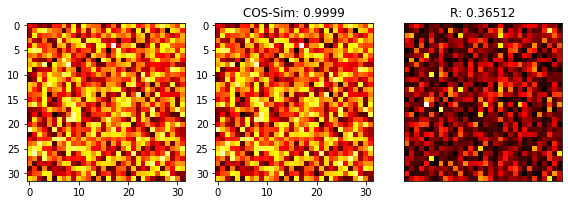

>>> name:stage_l3_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


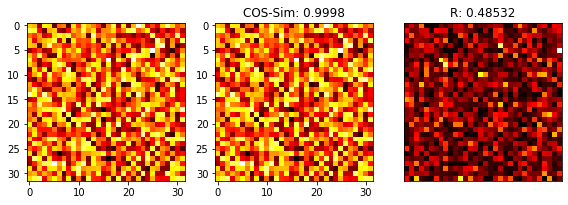

>>> name:stage_r3_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


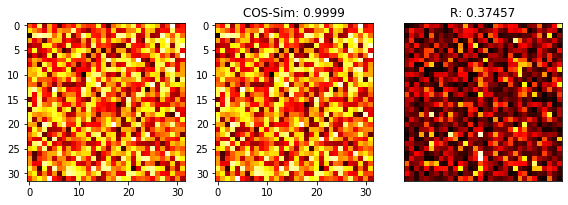

>>> name:stage_l3_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


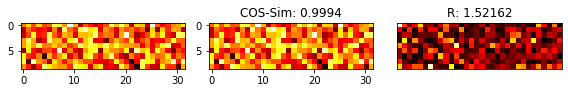

>>> name:stage_r3_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


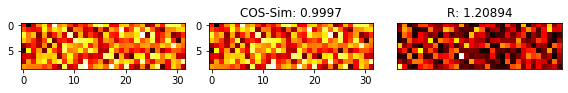

>>> name:stage_l3_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


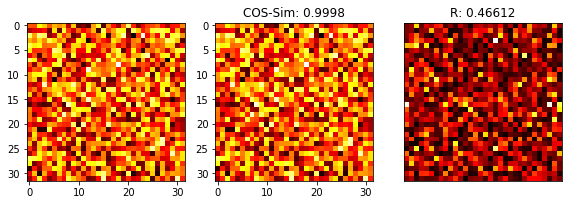

>>> name:stage_r3_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


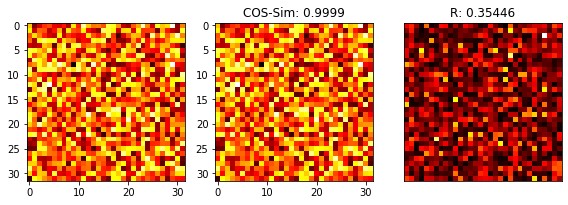

>>> name:stage_l4_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 64, 32)


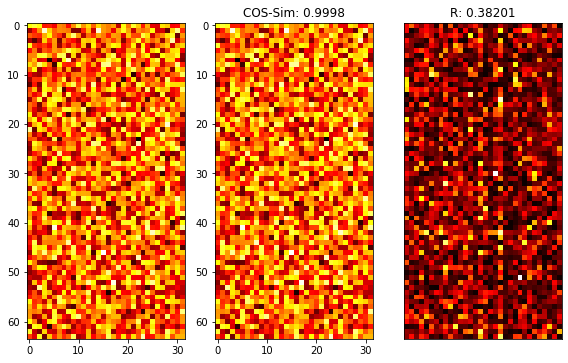

>>> name:stage_r4_down_pw_conv_r1/kernel:0 weight shape: (1, 1, 64, 32)


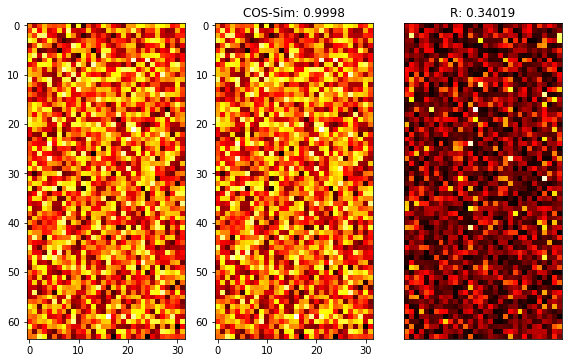

>>> name:stage_l4_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 64, 1)


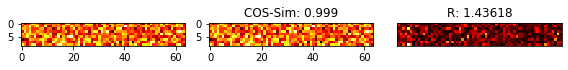

>>> name:stage_l4_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


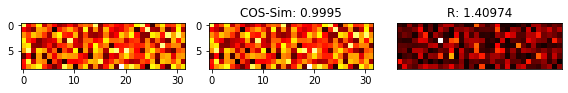

>>> name:stage_r4_down_dw_conv_l1/depthwise_kernel:0 weight shape: (3, 3, 64, 1)


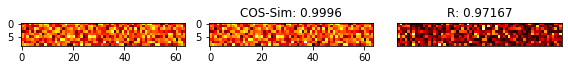

>>> name:stage_r4_down_dw_conv_r1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


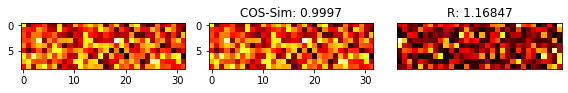

>>> name:stage_l4_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 64, 32)


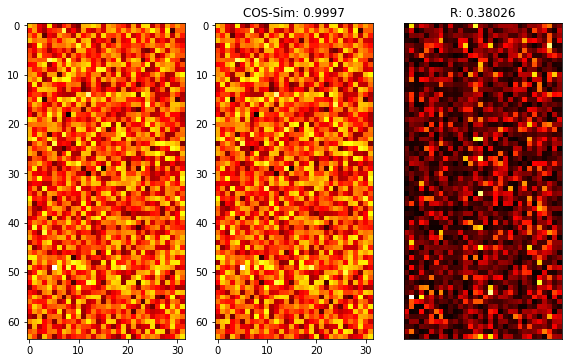

>>> name:stage_l4_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


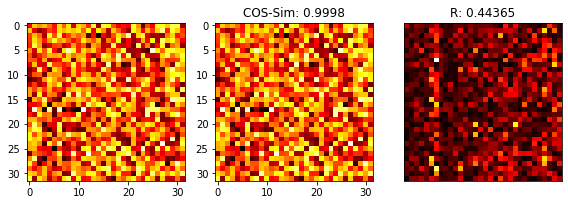

>>> name:stage_r4_down_pw_conv_l1/kernel:0 weight shape: (1, 1, 64, 32)


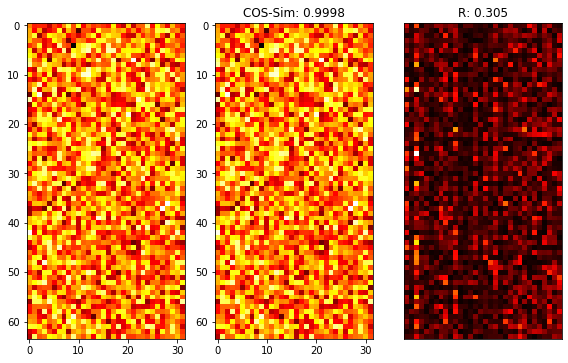

>>> name:stage_r4_down_pw_conv_r2/kernel:0 weight shape: (1, 1, 32, 32)


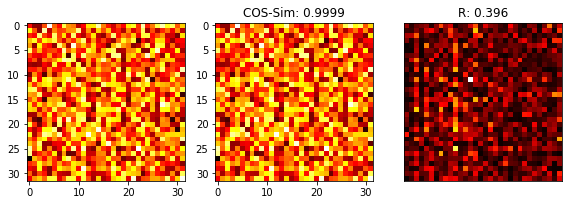

>>> name:stage_l4_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


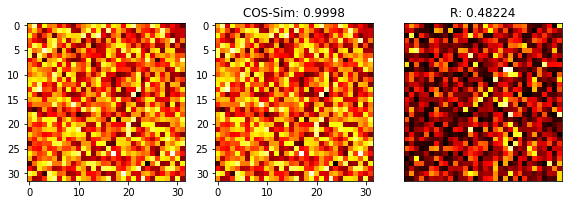

>>> name:stage_r4_basic_pw_conv1/kernel:0 weight shape: (1, 1, 32, 32)


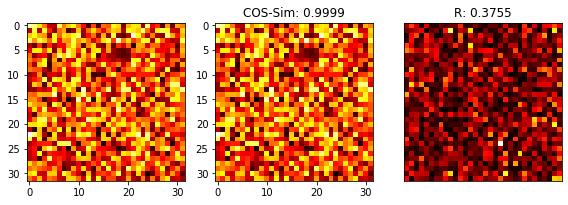

>>> name:stage_l4_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


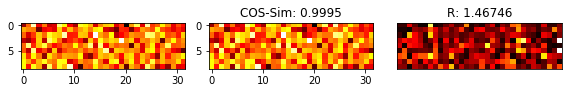

>>> name:stage_r4_basic_dw_conv1/depthwise_kernel:0 weight shape: (3, 3, 32, 1)


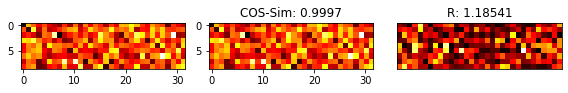

>>> name:stage_l4_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


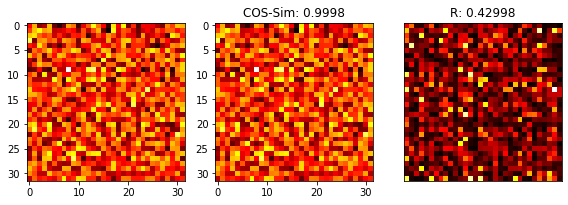

>>> name:stage_r4_basic_pw_conv2/kernel:0 weight shape: (1, 1, 32, 32)


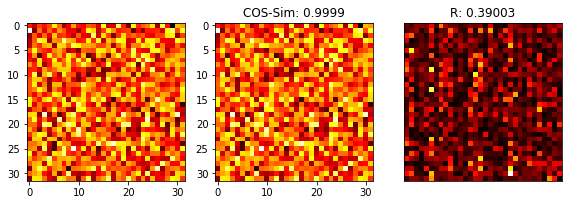

>>> name:support_fc1/kernel:0 weight shape: (42, 64)


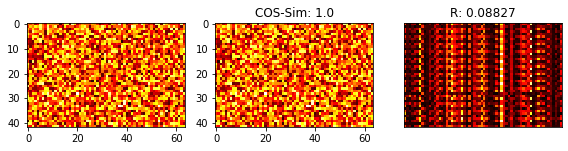

>>> name:support_fc2/kernel:0 weight shape: (64, 32)


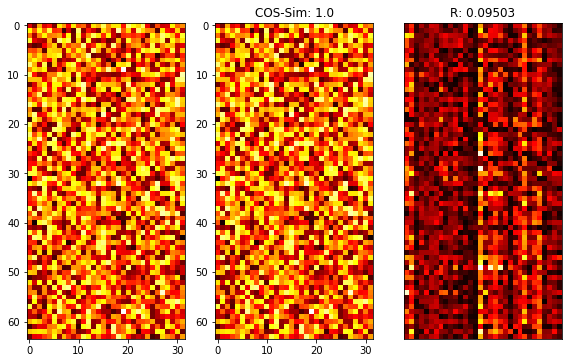

>>> name:eye_fc1/kernel:0     weight shape: (128, 64)


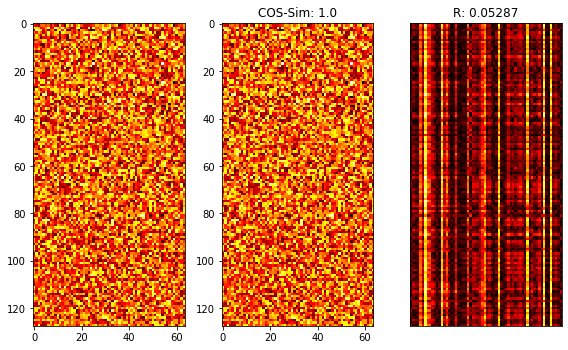

>>> name:support_fc3/kernel:0 weight shape: (32, 32)


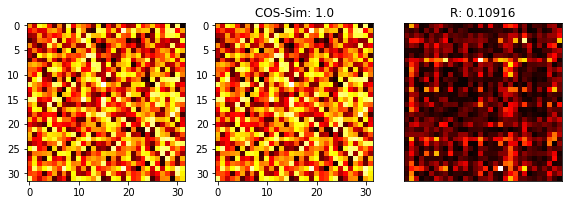

>>> name:final_fc1/kernel:0   weight shape: (96, 8)
[[0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.001 0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.001 0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.001 0.001 0.001 0.    0.    0.002 0.    0.001]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.001 0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.   ]
 [0.    0.002 0.002 0.    0.    0.002 0.    0.001]
 [0.    0.    0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.001 0.    0.  

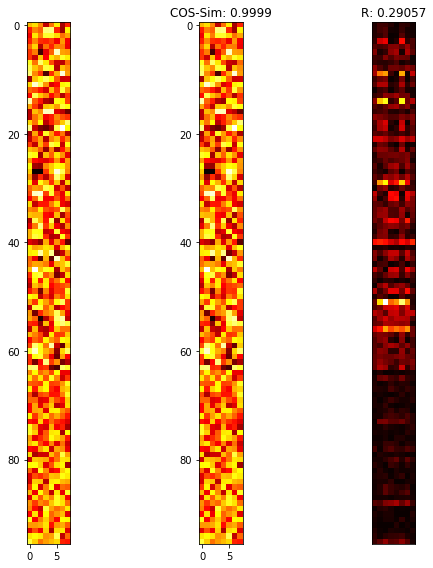

>>> name:final_fc1/bias:0     weight shape: (8,)
[w_x]: [[ 0.00070026  0.00285392]
 [ 0.00671797 -0.00585221]
 [ 0.00800791 -0.00339884]
 [ 0.0024542   0.00142235]]
[w_y]: [[ 0.00057692  0.00264914]
 [ 0.00608047 -0.00511974]
 [ 0.00717595 -0.0031924 ]
 [ 0.00231043  0.00120915]]
[[0.006 0.003 0.003 0.008]
 [0.007 0.012 0.013 0.007]]


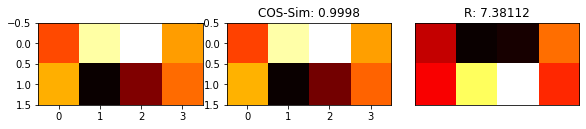

>>> name:final_fc2/kernel:0   weight shape: (8, 2)
[w_x]: [[-0.656711   -0.71856225 -0.62856704  0.3458729   0.321758    0.8529147
  -0.29901057 -0.37831604]
 [ 0.70664823 -0.01533981 -0.23400383 -0.7486648  -0.83047855  0.12951829
   0.80561525  0.28993016]]
[w_y]: [[-0.6600845  -0.7186403  -0.62747973  0.34935087  0.3254188   0.8508562
  -0.3032013  -0.38268852]
 [ 0.7044198  -0.01195227 -0.22953205 -0.74574065 -0.82445943  0.11907452
   0.8000316   0.28793594]]
[[0.002 0.   ]
 [0.    0.002]
 [0.    0.002]
 [0.002 0.001]
 [0.002 0.002]
 [0.    0.004]
 [0.002 0.001]
 [0.002 0.   ]]


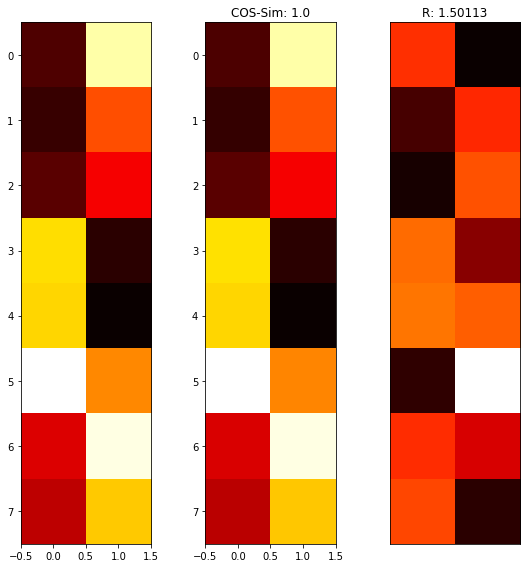

In [16]:
# compare(18, 19)
compare(34, 35)

# 평가

# 웨이트 변화량 실험

In [14]:
def cos_sim(x, y, eps=1e-08):
    norm_x = np.linalg.norm(x) + eps 
    norm_y = np.linalg.norm(y) + eps
    return np.dot(x, y) / (norm_x * norm_y)

In [17]:
def draw_weight_compare(w_x, w_y, idx, fs=(4,4)):
    # select layer
    wx_name, x = w_x[idx]
    wy_name, y = w_y[idx]
    
    if 'norm' in wx_name:
        return
    
    print(">>> name:{:20s} weight shape:".format(wx_name), x.shape)
    
    x, y = np.squeeze(x), np.squeeze(y)
    
    # weight reshape
    if len(x.shape) < 2:
        x = x.reshape(2, int(x.shape[-1]/2))
        y = y.reshape(2, int(y.shape[-1]/2))
    else:
        x = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])
        y = y.reshape(np.prod(y.shape[:-1]), y.shape[-1])
    
    if np.prod(x.shape) < 33:
        print("[w_x]:", x.T)
        print("[w_y]:", y.T)
        
    # full - weight similarity
    sim = np.around(cos_sim(x.flatten(), y.flatten()), decimals=4)
    
    # normalize
    avg_x, avg_y = np.mean(x), np.mean(y)
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    
    x = (x - avg_x) / (max_x - min_x)
    y = (y - avg_y) / (max_y - min_y)
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    
    # compute diff
    d = np.absolute(x - y)
    s = np.around(np.mean(d) * 1000, decimals=5)
    
    # if 'final' in wx_name:
    #     print(np.around(d, decimals=3))
    
    cm = 'hot'
    plt.figure(figsize=fs)
    plt.subplot(1, 3, 1)
    plt.imshow(x, cmap=plt.get_cmap(cm))
    plt.subplot(1, 3, 2)
    plt.imshow(y, cmap=plt.get_cmap(cm))
    plt.title('COS-Sim: {}'.format(sim))
    plt.subplot(1, 3, 3)
    plt.title('R: {}'.format(s))
    plt.imshow(d, cmap=plt.get_cmap(cm))

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    plt.show()